<center>
<h2>
Assingment 2
</h2>
</center>

<center>
<h2></h2>
<h3></h3>
<h3></h3>
<h3>Rasmus Eliasson & Oskar Flodin</h3>
<img src="bth.png" width="100">

<mail>rael23@student.bth.se</mail>

<mail>osfl22@student.bth.se</mail>
<h5>2025-05-31</h5>
</center>

<center>
<h2>Visualization Dataset 1</h2>
</center>

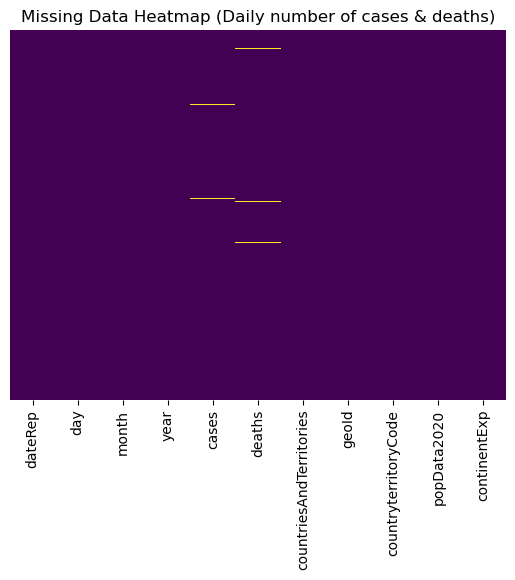

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import plotly.graph_objects as go
import matplotlib.dates as mdates
import os
import plotly.offline as py
import ipywidgets as widgets
import re
from IPython.display import display


# Get current working directory.
path = os.getcwd()
dataset_folder = 'Assignment 2_datasets'

path = os.path.join(path, dataset_folder)


# Read the files.
covid_daily_admission_original = pd.read_csv(os.path.join(path, '1.COVID-19_daily_number_of_new_cases_and_deaths.csv'))
covid_vaccination_original = pd.read_csv(os.path.join(path, '2.COVID-19_vaccination.csv'))
covid_ICU_original = pd.read_csv(os.path.join(path, '3.COVID-19_hospital_and_ICU_admission_rates.csv'))

covid_daily_admission = covid_daily_admission_original.copy()
covid_vaccination = covid_vaccination_original.copy()
covid_ICU = covid_ICU_original.copy()


covid_daily_admission['dateRep'] = pd.to_datetime(covid_daily_admission['dateRep'], dayfirst=True)

sns.heatmap(covid_daily_admission.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Data Heatmap (Daily number of cases & deaths)")
plt.show()


In [94]:
#############################
#       data set 1          #
#############################

# visualization #
years = sorted(covid_daily_admission['year'].unique())

covid_daily_admission['cases'] = covid_daily_admission['cases'].where(covid_daily_admission['cases'] >= 0, np.nan)
covid_daily_admission['deaths'] = covid_daily_admission['deaths'].where(covid_daily_admission['deaths'] >= 0, np.nan)

covid_daily_admission['log Cases'] = np.log1p(covid_daily_admission['cases'])
covid_daily_admission['log Deaths'] = np.log1p(covid_daily_admission['deaths'])

def func(year):

    df = covid_daily_admission[covid_daily_admission['year'] == year]

    plt.figure(figsize=(16, 6))
    sns.boxplot(
        x='countriesAndTerritories',
        y='log Cases',
        data=df
    )
    plt.title(f"Cases per Country in {year}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(16, 6))
    sns.boxplot(
        x='countriesAndTerritories',
        y='log Deaths',
        data=df,
        color= 'Red'
    )
    plt.title(f"Deaths per Country in {year}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


widgets.interact(func, year = years);


interactive(children=(Dropdown(description='year', options=(2020, 2021, 2022), value=2020), Output()), _dom_cl…

<center>
<h2>Data cleaning dataset 1</h2>
</center>

In [95]:
def remove_outliers(group, window=3):
    group_fixed = group.copy()

    # Work only with log columns
    log_columns = ['log Cases', 'log Deaths']
    Q1 = group[log_columns].quantile(0.25)
    Q3 = group[log_columns].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    Cases_Nulls_index = []
    Deaths_Nulls_index = []
    cases_outliers = 0
    deaths_outliers = 0


    # Add new columns to mark outliers
    group_fixed['is_outlier_cases'] = False
    group_fixed['is_outlier_deaths'] = False
    group_fixed['outlier_reason_cases'] = None
    group_fixed['outlier_reason_deaths'] = None

    def handle_points(idx, column):
        pos = group.index.get_loc(idx)
        window_start = max(pos - window, 0)
        window_end = min(pos + window + 1, len(group))

        neighbors = group.iloc[window_start:window_end][column].drop(idx, errors='ignore').dropna()
        if not neighbors.empty:
            group_fixed.at[idx, column] = neighbors.mean()
        else:
            group_fixed.at[idx, column] = group[column].mean()


    # Go through each row
    for idx in group.index:

        #####################
        # Handle log Cases  #
        #####################
        val_cases = group.at[idx, 'log Cases']
        if pd.isna(val_cases):
            Cases_Nulls_index.append(idx)

            group_fixed.at[idx, 'is_outlier_cases'] = True
            group_fixed.at[idx, 'outlier_reason_cases'] = 'Negatives'
            cases_outliers += 1
        elif val_cases < lower_bound['log Cases'] or val_cases > upper_bound['log Cases']:
            cases_outliers += 1
            group_fixed.at[idx, 'is_outlier_cases'] = True
            group_fixed.at[idx, 'outlier_reason_cases'] = 'IQR'

            handle_points(idx, 'log Cases')


        #####################
        # Handle log Deaths #
        #####################
        val_deaths = group.at[idx, 'log Deaths']
        if pd.isna(val_deaths):
            Deaths_Nulls_index.append(idx)

            # outliers_in_group.append((idx, 'log Deaths', 'NaN'))
            group_fixed.at[idx, 'is_outlier_deaths'] = True
            group_fixed.at[idx, 'outlier_reason_deaths'] = 'Negative'
            deaths_outliers += 1
        elif val_deaths < lower_bound['log Deaths'] or val_deaths > upper_bound['log Deaths']:
            Deaths_Nulls_index.append(idx)
            
            group_fixed.at[idx, 'is_outlier_deaths'] = True
            group_fixed.at[idx, 'outlier_reason_deaths'] = 'IQR'

            deaths_outliers += 1

    # Fill outliers/nulls using neighbors
    for idx in Cases_Nulls_index:
        handle_points(idx, 'log Cases')
    for idx in Deaths_Nulls_index:
        handle_points(idx, 'log Deaths')


    return group_fixed


covid_daily_admission_cleaned = (
    covid_daily_admission
    .groupby(['countriesAndTerritories', 'year'])
    .apply(remove_outliers)
    .reset_index(drop=True)
)



covid_daily_admission_cleaned['cases'] = np.expm1(covid_daily_admission_cleaned['log Cases'])
covid_daily_admission_cleaned['deaths'] = np.expm1(covid_daily_admission_cleaned['log Deaths'])

print("Outliers cases", \
      len(covid_daily_admission_cleaned[covid_daily_admission_cleaned['is_outlier_cases'] == True]))

print("Outliers deaths", \
      len(covid_daily_admission_cleaned[covid_daily_admission_cleaned['is_outlier_deaths'] == True]))


Outliers cases 573
Outliers deaths 966


C:\Users\rasmu\AppData\Local\Temp\ipykernel_17476\3384947350.py:90: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



<center>
<h2>Visualization dataset 2</h2>
</center>

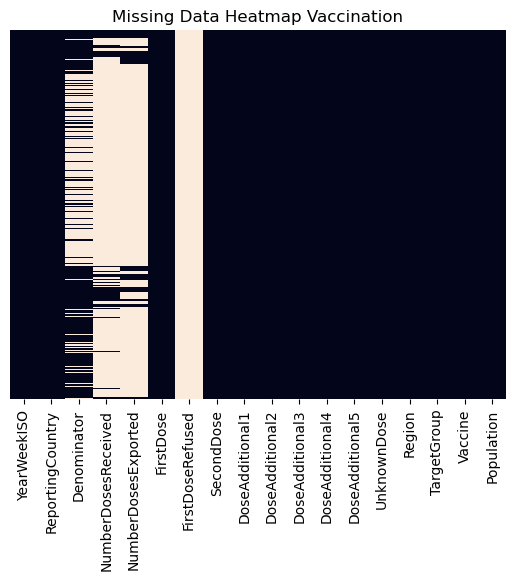

In [96]:
#############################
#       data set 2          #
#############################
sns.heatmap(covid_vaccination.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Data Heatmap Vaccination")
plt.show()

<center>
<h2>Data cleaning dataset 2</h2>
</center>

In [97]:
# Filter out rows with unknown vaccine
covid_vaccination = covid_vaccination_original[covid_vaccination_original["Vaccine"] != "UNK"]

remove_columns = ['NumberDosesReceived', 'NumberDosesExported', 'Denominator', 'FirstDoseRefused'] 
covid_vaccination = covid_vaccination_original.drop(columns=remove_columns)
covid_vaccination = covid_vaccination.drop_duplicates().reset_index(drop=True)

# List of dose columns to sum
dose_columns = [
    "FirstDose", "SecondDose", "DoseAdditional1", "DoseAdditional2",
    "DoseAdditional3", "DoseAdditional4", "DoseAdditional5", "UnknownDose"
]

# Convert dose columns to numeric (handle missing values)
covid_vaccination[dose_columns] = covid_vaccination[dose_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

# Create a new column for total doses given
covid_vaccination['TotalDosesGiven'] = covid_vaccination[dose_columns].sum(axis=1)


# Safely convert 'YearWeekISO' to datetime (ISO week to Monday of that week)
covid_vaccination["Date"] = pd.to_datetime(
    covid_vaccination["YearWeekISO"] + "-1",
    # ISO year, week, weekday (1 = Monday)
    format="%G-W%V-%u",
    errors='coerce'
)

# Drop rows with invalid dates (if any), then sort
covid_vaccination = covid_vaccination.dropna(subset=["Date"])
covid_vaccination = covid_vaccination.sort_values(by=['Date', 'YearWeekISO']).reset_index()


In [98]:
def get_or_sum_row(group_df, label, components, yearweek, country):
    if label in group_df['TargetGroup'].values:
        return group_df[group_df['TargetGroup'] == label].head(1)

    sub = group_df[group_df['TargetGroup'].isin(components)]
    if sub.empty:
        return None

    dose_columns = ['TotalDosesGiven', 'FirstDose', 'SecondDose', 'DoseAdditional1', 'DoseAdditional2',
                    'DoseAdditional3', 'DoseAdditional4', 'DoseAdditional5', 'UnknownDose']

    # Prepare aggregated row
    summed_data = {
        'YearWeekISO': yearweek,
        'ReportingCountry': country,
        'TargetGroup': label,
        'Population': sub['Population'].max()
    }

    for col in dose_columns:
        summed_data[col] = sub[col].sum()

    for col in ['Region', 'Vaccine', 'Date']:
        mode_val = sub[col].mode()
        summed_data[col] = mode_val.iloc[0] if not mode_val.empty else sub[col].iloc[0]

    return pd.DataFrame([summed_data])


rows_fixed = []

# Group by ReportingCountry and YearWeekISO and Vaccine
for (yearweek, country, vaccine), group_df in covid_vaccination.groupby(['YearWeekISO', 'ReportingCountry', 'Vaccine']):
    group_definitions = [
        ('Age<18', ['Age0_4', 'Age5_9', 'Age10_14', 'Age15_17']),
        ('1_Age<60', ['Age18_24', 'Age25_49', 'Age50_59']),
        ('1_Age60+', ['Age60_69', 'Age70_79', 'Age80+']),
    ]

    for label, components in group_definitions:
        row = get_or_sum_row(group_df, label, components, yearweek, country)
        if row is not None:
            rows_fixed.append(row)

    # Add AgeUnk directly if it exists
    if 'AgeUnk' in group_df['TargetGroup'].values:
        rows_fixed.append(group_df[group_df['TargetGroup'] == 'AgeUnk'].head(1))

# Concatenate final DataFrame
covid_vacc_cleaned = pd.concat(rows_fixed, ignore_index=True)

# Drop index column if it exists
if 'index' in covid_vacc_cleaned.columns:
    covid_vacc_cleaned = covid_vacc_cleaned.drop(columns='index')


#########################
#       Validation      #
#########################
print("Actual length after cleaning: ",len(covid_vacc_cleaned))
print("Expected length after cleaning: ", len(covid_vaccination.groupby(['ReportingCountry', 'YearWeekISO', 'Vaccine'])) * 3)

Actual length after cleaning:  48512
Expected length after cleaning:  57753


In [99]:
# Mapping rules
def simplify_group(value):
    if 'Age<18' in value:
        return 'Child'
    elif 'Age60+' in value:
        return 'Senior'
    elif 'Age<60' in value:
        return 'Adult'
    else:
        return 'Unknown'

# Apply transformation
covid_vacc_cleaned['TargetGroupSimplified'] = covid_vacc_cleaned['TargetGroup'].apply(simplify_group)

<center>
<h2>Visualization dataset 3</h2>
</center>

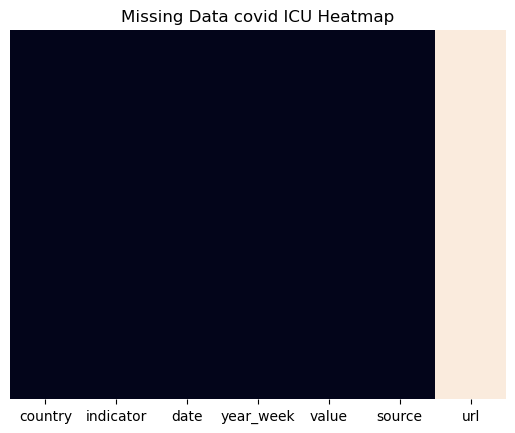

In [100]:
#############################
#       data set 3          #
#############################
sns.heatmap(covid_ICU_original.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Data covid ICU Heatmap")
plt.show()


In [101]:
covid_ICU = covid_ICU_original.drop(columns='url')

# Extract year.
covid_ICU['year'] = covid_ICU['year_week'].str.extract(r'(^\d{4})')
covid_ICU['year'] = covid_ICU['year'].astype(int)

daily_hospital_occ = covid_ICU[covid_ICU['indicator'] == 'Daily hospital occupancy'].copy()
daily_icu_occ = covid_ICU[covid_ICU['indicator'] == 'Daily ICU occupancy'].copy()

weekly_admissions = covid_ICU[covid_ICU['indicator'] == 'Weekly new hospital admissions per 100k'].copy()

weekly_icu_admissions = covid_ICU[covid_ICU['indicator'] == 'Weekly new ICU admissions per 100k'].copy()


# Get sorted list of unique years
years = sorted(weekly_admissions['year'].unique())


for df, col in [(weekly_admissions, 'log Admissions'),
                (weekly_icu_admissions, 'log ICU Admissions'),
                (daily_hospital_occ, 'log Admissions'),
                (daily_icu_occ, 'log ICU Admissions')]:
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df['value'] = df['value'].where(df['value'] >= 0, np.nan)
    df[col] = np.log1p(df['value'])


daily_hospital_occ_vis = daily_hospital_occ.copy()
daily_icu_occ_vis = daily_icu_occ.copy()
weekly_admissions_vis = weekly_admissions.copy()
weekly_icu_admissions_vis = weekly_icu_admissions.copy()


# Visualization function
def plot_admissions(year):
    df_hosp = weekly_admissions_vis[weekly_admissions_vis['year'] == year]
    df_icu = weekly_icu_admissions_vis[weekly_icu_admissions_vis['year'] == year]

    plt.figure(figsize=(16, 6))
    sns.boxplot(
        x='country',
        y='log Admissions',
        data=df_hosp
    )
    plt.title(f"Weekly Hospital Admissions per 100k in {year}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16, 6))
    sns.boxplot(
        x='country',
        y='log ICU Admissions',
        data=df_icu,
        color='red'
    )
    plt.title(f"Weekly ICU Admissions per 100k in {year}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


    df_hosp_occ = daily_hospital_occ_vis[daily_hospital_occ_vis['year'] == year]
    df_icu_occ = daily_icu_occ_vis[daily_icu_occ_vis['year'] == year]

    plt.figure(figsize=(16, 6))
    sns.boxplot(
        x='country',
        y='log Admissions',
        data=df_hosp_occ
    )
    plt.title(f"Daily Hospital Occupancy in {year}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16, 6))
    sns.boxplot(
        x='country',
        y='log ICU Admissions',
        data=df_icu_occ,
        color='red'
    )
    plt.title(f"Daily ICU Occupancy in {year}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Interactive widget
widgets.interact(plot_admissions, year=years);

interactive(children=(Dropdown(description='year', options=(2020, 2021, 2022, 2023), value=2020), Output()), _…

<center>
<h2>Data cleaning dataset 3</h2>
</center>

In [102]:

covid_ICU['year'] = covid_ICU['year_week'].str.extract(r'(^\d{4})')
covid_ICU['year'] = covid_ICU['year'].astype(int)

daily_hospital_occ = covid_ICU[covid_ICU['indicator'] == 'Daily hospital occupancy']
daily_icu_occ = covid_ICU[covid_ICU['indicator'] == 'Daily ICU occupancy']

weekly_admissions = covid_ICU[covid_ICU['indicator'] == 'Weekly new hospital admissions per 100k'].copy()
weekly_icu_admissions = covid_ICU[covid_ICU['indicator'] == 'Weekly new ICU admissions per 100k'].copy()


outliers_numb = 0

def remove_outliers2(series, window=3):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    series_fixed = series.copy()
    Nulls_index = []

    global outliers_numb

    def handle_points(pos_idx):
        global outliers_numb

        outliers_numb += 1
        start = max(0, pos_idx - window)
        end = min(len(series_fixed), pos_idx + window + 1)
        neighbors = series_fixed.iloc[start:end].drop(series_fixed.index[pos_idx], errors='ignore').dropna()
        if not neighbors.empty:
            series_fixed.iloc[pos_idx] = neighbors.mean()
        else:
            series_fixed.iloc[pos_idx] = series_fixed.mean()

    for pos_idx in range(len(series_fixed)):
        val = series_fixed.iloc[pos_idx]
        if pd.isna(val):
            Nulls_index.append(pos_idx)
        elif (val < lower_bound) or (val > upper_bound):
            handle_points(pos_idx)

    for pos_idx in Nulls_index:
        handle_points(pos_idx)
    return series_fixed


datasets = {
    "weekly_admissions": weekly_admissions,
    "weekly_icu_admissions": weekly_icu_admissions,
    "daily_icu_occ": daily_icu_occ,
    "daily_hospital_occ": daily_hospital_occ
}

cleaned_frames = []
outlier_labels = {
    "weekly_admissions": "weekly admissions",
    "weekly_icu_admissions": "weekly ICU admissions",
    "daily_icu_occ": "daily ICU occupancy",
    "daily_hospital_occ": "daily hospital occupancy"
}

for name, df in datasets.items():
    cleaned_df = df.copy()
    cleaned_df['value'] = (
        df
        .groupby(['country', 'year'])['value']
        .transform(remove_outliers2)
    )
    print(f'Amount of outliers "{outlier_labels[name]}": {outliers_numb}')
    outliers_numb = 0

    # Add identifier for merging
    cleaned_df['data_type'] = name
    cleaned_frames.append(cleaned_df)

# Concatenate into one final DataFrame
covid_ICU_cleaned = pd.concat(cleaned_frames, ignore_index=True)


Amount of outliers "weekly admissions": 150
Amount of outliers "weekly ICU admissions": 147
Amount of outliers "daily ICU occupancy": 380
Amount of outliers "daily hospital occupancy": 449


<h2>Q1</h2>
<p>Since 2020 till 2022, which top 10 countries reported the most number of cases of COVID-19 in quarters per year (Q1–Q4 in each year)?</p>
<ul>
  <li>Do you find these numbers relatively high compared to the country’s population?</li>
  <li>Do you see any connection among these countries regarding their geographical locations and the period in which most cases are observed?</li>
</ul>


In [103]:
from matplotlib.ticker import FuncFormatter
#########################################
#   Gather data by quarter then plot    #
#########################################

covid_daily_admission_cleaned['dateRep'] = pd.to_datetime(
    covid_daily_admission_cleaned['dateRep'], dayfirst=True)
covid_daily_admission_cleaned['quarter'] = covid_daily_admission_cleaned['dateRep'].dt.to_period('Q')

data_new_cases_and_deaths = (
    covid_daily_admission_cleaned.
    groupby(['quarter', 'countriesAndTerritories'])['cases'].sum().reset_index()
    )

pivot_quarterly_cases = data_new_cases_and_deaths.pivot(
    index='quarter', columns='countriesAndTerritories', values='cases')

quaters = ["Q1", "Q2", "Q3", "Q4"]
years = pivot_quarterly_cases.index.year.unique().tolist()

def func(year):
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    axes = axes.flatten()

    for i, qu in enumerate(quaters):
        period = str(year) + qu
        ax = axes[i]

        if period in pivot_quarterly_cases.index:
            data = pivot_quarterly_cases.loc[period].nlargest(10)
            sns.barplot(x=data.index, y=data.values, ax=ax)
            ax.set_title(f'COVID-19 Cases by Country - {period}', fontsize=16)
            ax.set_xlabel('Country', fontsize=14)
            ax.set_ylabel('Number of Cases', fontsize=14)
            ax.tick_params(axis='x', labelsize=12)
            ax.tick_params(axis='y', labelsize=12)

            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

        else:
            ax.set_title(f'{period} - No Data')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

widgets.interact(func, year=years);

interactive(children=(Dropdown(description='year', options=(2020, 2021, 2022), value=2020), Output()), _dom_cl…

<p>
  As can be seen in the plots the countries that most frequently reported the highest
  number of COVID-19 cases per quarter between 2020 and 2022, were <strong>France, Germany, Italy,</strong> and <strong>Spain</strong>.
  These countries appeared consistently in the top 5 rankings across nearly every quarter.
  Smaller countries such as <strong>Belgium, the Netherlands,</strong> and <strong>Portugal</strong> appeared
  more sporadically and typically in the lower half of the top 10.
</p>
<hr>
<p>
  The high case counts in absolute terms can be partially explained by population
  size. However, in some quarters — especially Q1 of 2022 — even smaller countries
  like <strong>Austria, Portugal,</strong> and <strong>Denmark</strong> reported several million cases, which is disproportionately high given their populations. This likely correlates with the rapid spread of the
  <em>Omicron</em> variant, which became dominant in early 2022.
</p>
<hr>
<p>
  A geographical pattern is also noticeable. Most of the countries consistently in
  the top 10 are located in <strong>Western and Southern Europe</strong>, and many share borders with eachother. This regional clustering suggests that geographic proximity and mobility between these nations may have contributed to case transmission. (see question 2 for visualization of the cases and deaths in EU/EES countries).
</p>
<hr>

<center>
  <h2>Conclusion</h2>
</center>
<p>
  The analysis highlights how both <strong>population size</strong> and <strong>geographical proximity</strong> played key roles in shaping the spread of COVID-19 across Europe between 2020 and 2022. The consistent appearance of countries like France, Germany, Italy, and Spain at the top of case rankings underscores these factors. Regional clustering and mobility further contributed to transmission patterns, especially during the Omicron surge.
</p>

<h2>Q2</h2>
<p>Visualize each country’s total number of cases and deaths on a map plot using their geographical locations in 2020, 2021, and 2022.</p>

In [104]:
yearly_country_data = covid_daily_admission.groupby(
    ['countriesAndTerritories', 'year']
)[['cases', 'deaths']]

yearly_country_data_sumamry = yearly_country_data.sum().reset_index()

# Ensure 'year' and 'country' columns are ready
yearly_country_data_sumamry['country'] = yearly_country_data_sumamry['countriesAndTerritories'].str.replace('_', ' ')

# Create one choropleth trace per year
data = []
years = sorted(yearly_country_data_sumamry['year'].unique())


def func(year):
    df = yearly_country_data_sumamry[yearly_country_data_sumamry['year'] == year]

    ########################
    #        Cases         #
    ########################
    worldmap = [
    dict(
        type="choropleth",
        locations=df["country"],
        locationmode="country names",
        z=df["cases"],
        autocolorscale=True,
        reversescale=False,
        marker=dict(line=dict(color="rgb(180,180,180)", width=0.5)),
        colorbar=dict(autotick=False, title='Cases'),
    )
    ]

    layout = dict(
        title=f"COVID-19 cases by Country in {year}",
        geo=dict(showframe=False, showcoastlines=True, projection=dict(type="Mercator")),
    )

    fig = dict(data=worldmap, layout=layout)
    py.iplot(fig, validate=False)

    ########################
    #        Deaths        #
    ########################
    worldmap = [
    dict(
        type="choropleth",
        locations=df["country"],
        locationmode="country names",
        z=df["deaths"],
        autocolorscale=True,
        reversescale=False,
        marker=dict(line=dict(color="rgb(180,180,180)", width=0.5)),
        colorbar=dict(autotick=False, title="Deaths"),
    )
    ]

    layout = dict(
        title=f"COVID-19 deaths by Country in {year}",
        geo=dict(showframe=False, showcoastlines=True, projection=dict(type="Mercator")),
    )

    fig = dict(data=worldmap, layout=layout)
    py.iplot(fig, validate=False)

widgets.interact(func, year = years);

interactive(children=(Dropdown(description='year', options=(2020, 2021, 2022), value=2020), Output()), _dom_cl…

<center>
<h2>Interpretation of the geographic plot</h2>
</center>
<ul>
  <li>
    Central and Southern European countries such as <strong>France, Germany, Italy,</strong> and <strong>Spain</strong> consistently show higher numbers of both cases and deaths.
  </li>
  <li>
    Countries that are geographically more isolated, such as the <strong>Nordic countries</strong> and <strong>Ireland</strong>, tend to have lower case numbers across all three years. This might be due to factors like lower population density, stricter border control, or earlier lockdown measures.
  </li>
  <li>
    There is a strong correlation between the number of cases and deaths: countries with the highest number of cases also tend to have the highest death toll. For example, in 2020 and 2021, <strong>France</strong> and <strong>Italy</strong> show both high case and death counts, which aligns with their overwhelmed healthcare systems during peaks of the pandemic.
  </li>
</ul>


<h2>Q3</h2>
<p>What are the top 3 popular vaccine brands that have been used across the EU/EEA?</p>
<ul>
  <li>Can you observe the same popularity at the country level?</li>
  <li>Are there any exceptions?</li>
</ul>


The top three vaccines administered are: Comirnaty (Pfizer), Moderna, AstraZeneca.


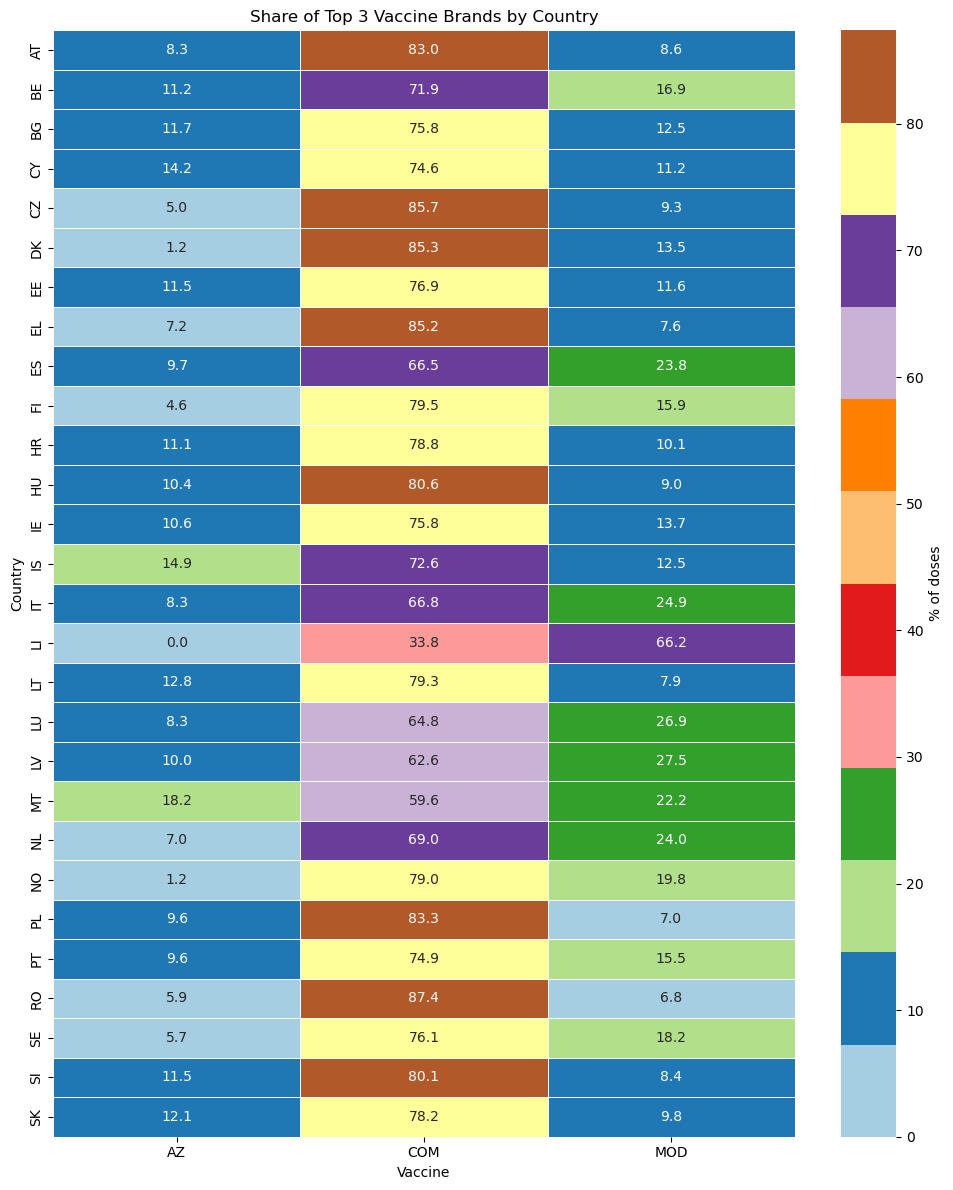

In [105]:
# Filter out Unknown vaccine.
covid_vacc_target_analysis = covid_vacc_cleaned[covid_vacc_cleaned["Vaccine"] != "UNK"]

grouped = covid_vacc_target_analysis.groupby(
    ['ReportingCountry', 'YearWeekISO', 'TargetGroup', 'Vaccine'],
    as_index=False
)['TotalDosesGiven'].sum()
grouped_sorted = grouped.sort_values(['ReportingCountry', 'TotalDosesGiven'], ascending=[True, False])

# Identify the top 3 vaccine brands globally by total doses given.
top_3_vaccines = covid_vacc_target_analysis.groupby("Vaccine")["TotalDosesGiven"].sum().sort_values(ascending=False).head(3).index.tolist()
top3_per_country = grouped[grouped['Vaccine'].isin(top_3_vaccines)]

vaccine_names = {'COM': 'Comirnaty (Pfizer)', 'MOD': 'Moderna', 'AZ': 'AstraZeneca'}
top_3_names = [vaccine_names.get(v, v) for v in top_3_vaccines]
print(f"The top three vaccines administered are: {', '.join(top_3_names)}.")


# Create a pivot table with countries as rows, vaccines as columns,
# and total doses given as values
pivot = top3_per_country.pivot_table(
    index='ReportingCountry',
    columns='Vaccine',
    values='TotalDosesGiven',
    aggfunc='sum', fill_value=0
    )

pivot_percent = pivot.div(pivot.sum(axis=1), axis=0) * 100

# Plot a heatmap to visualize the percentage distribution
# of the top 3 vaccine brands per country.
plt.figure(figsize=(10, 12))
sns.heatmap(
    pivot_percent, annot=True, fmt=".1f", cmap="Paired",
    linewidths=.5, cbar_kws={'label': '% of doses'}
)
plt.title("Share of Top 3 Vaccine Brands by Country")
plt.xlabel("Vaccine")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

<p>
  In Europe, the top three vaccines were <strong>COM (Pfizer)</strong>, <strong>MOD (Moderna)</strong>, and <strong>AZ (AstraZeneca)</strong>, in that order.
  The heat map shows the distribution of these vaccines among EU/EEA countries as percentages.
</p>
<p>
  Almost all countries had between <strong>59.6%</strong> and <strong>85.7%</strong> of all doses as COM, except Liechtenstein where it was only <strong>33.8%</strong> and the most used vaccine was MOD.
  The second most popular vaccine varied more between countries but generally favored MOD.
</p>
<hr>
<p>
  One limitation in the data representation is that Germany and France reported mostly unknown vaccine brands, despite representing a large portion of the European population.
</p>


<h2>Q4</h2>
<p>Considering the previous question, which target groups mainly received these vaccine brands in each country?</p>


In [106]:
from matplotlib.colors import LogNorm

top_vaccines = ['COM', 'MOD', 'AZ']

covid_vacc_cleaned['DosesPer100k'] = (
    (covid_vacc_cleaned['TotalDosesGiven'] / covid_vacc_cleaned['Population']) * 100000
)

def plot_heatmap_by_vaccine(vaccine):
    df_vac = covid_vacc_cleaned[covid_vacc_cleaned['Vaccine'] == vaccine]

    heatmap_data = df_vac.groupby(
        ['ReportingCountry', 'TargetGroupSimplified'])['DosesPer100k'].sum().unstack(fill_value=0)


    heatmap_data = heatmap_data[['Child', 'Adult', 'Senior']]

    plt.figure(figsize=(14, 10))
    
    sns.heatmap(heatmap_data + 1,
                norm=LogNorm(vmin=1,
                vmax=heatmap_data.values.max()
                ), cmap="Paired", linewidths=.5,
                cbar_kws={'label': f'Doses per 100k (vaccine: {vaccine})'})
    plt.title(f"Doses per 100k inhabitants by target group and country ({vaccine})")
    plt.ylabel("Country")
    plt.xlabel("Target Group")
    plt.tight_layout()
    plt.show()

widgets.interact(plot_heatmap_by_vaccine, vaccine=top_vaccines);

interactive(children=(Dropdown(description='vaccine', options=('COM', 'MOD', 'AZ'), value='COM'), Output()), _…

<p>
  The three heatmaps show doses for each vaccine in the top 3 per 100,000 inhabitants by target group and country. The target groups are children (&lt;18), adults (18–59), and seniors (60+). The color scale is logarithmic to highlight both small and large differences.
</p>
<hr>
<center>
<h2>Conclusion</h2>
</center>
<ul>
  <li>
    Pfizer is generally used across all target groups but is heavily dominant among children and is the most commonly used vaccine for that group.
  </li>
  <li>
    Moderna shows a similar pattern to COM, with all three target groups receiving the vaccine; the main difference is the number of doses administered.
  </li>
  <li>
    AstraZeneca primarily targets seniors and adults. Only in two countries was there a higher amount of children vaccinated with AstraZeneca.
  </li>
</ul>


<a id="question-5"></a>
<h2>Q5</h2>
<p>Which countries are the most skeptical towards the first dose of the COVID-19 vaccine?</p>
<ul>
  <li>Do you think this matter had any impact on the hospitalization level?</li>
</ul>

In [107]:
# Go through all the countries & 
#   search for the latest ones to start giving first dose.
df = covid_vaccination.copy()
sceptical = []

i = 0
while i < len(df):
    idx = df.index[i]
    row = df.loc[idx]

    if row['FirstDose'] > 0:
        # Remove all rows from that country.
        df = df[df['ReportingCountry'] != row['ReportingCountry']]
        i = 0
        continue
    else:
        sceptic_i = 0
        while sceptic_i < len(sceptical):
            if sceptical[sceptic_i][1] == row['ReportingCountry']:
                sceptical.pop(sceptic_i)
                sceptic_i = 0
                continue
            sceptic_i += 1

        sceptical.append((idx, row['ReportingCountry']))

        if len(sceptical) > 3:
            sceptical.pop(0)
    i += 1


# Generall code to retrive the countrys name by geoid from the dataframes.
unique_countries = covid_daily_admission[['geoId', 'countriesAndTerritories']].drop_duplicates(subset='geoId')
sceptical_df = pd.DataFrame(sceptical, columns=['idx', 'geoId'])
merged_df = pd.merge(sceptical_df, unique_countries, on='geoId', how='left')

sceptical_country = merged_df['countriesAndTerritories'].tolist()
late_vaccinator_country = merged_df['geoId'].tolist()
print("Latest to start vaccinate")
print(', '.join(sceptical_country), end='\n\n')


###############################
#       Least vaccinated      #
###############################

# Ensure Population is numeric
covid_vacc_cleaned['Population'] = pd.to_numeric(covid_vacc_cleaned['Population'], errors='coerce')

total_doses = covid_vacc_cleaned.groupby('ReportingCountry')['TotalDosesGiven'].sum()
population = covid_vacc_cleaned.groupby('ReportingCountry')['Population'].first()

# Compute per capita vaccination
pop_sceptics = total_doses / population
pop_sceptics = pop_sceptics.sort_values()


# Get top 3 least vaccinated country codes.
least_vaccinated = pop_sceptics.nsmallest(3)

# Convert from country codes to country names.
sceptical_country_names = []
for country_code in least_vaccinated.index:
    match = covid_daily_admission[covid_daily_admission['geoId'] == country_code]
    if not match.empty:
        country_name = match[['countriesAndTerritories']].iloc[0]['countriesAndTerritories']
        sceptical_country_names.append((country_code, country_name))
    else:
        sceptical_country_names.append((country_code, "Unknown"))

print("Countries with sceptism towards multiple vaccine dosses:")
# Print results.
for code, name in sceptical_country_names:
    print(f"{name} ({code})")

sceptical_countries = list(pop_sceptics.nsmallest(3).index)

Latest to start vaccinate
Liechtenstein, Netherlands, Romania

Countries with sceptism towards multiple vaccine dosses:
Bulgaria (BG)
Romania (RO)
Croatia (HR)


In [108]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr


# Map country and merge on population.
country_dict = (
    covid_daily_admission_cleaned[['geoId', 'countriesAndTerritories']]
    .drop_duplicates()
    .set_index('geoId')['countriesAndTerritories']
    .to_dict()
)
covid_vacc_cleaned['country'] = covid_vacc_cleaned['ReportingCountry'].map(country_dict)

latest_population = (
    covid_daily_admission_cleaned
    .drop_duplicates('countriesAndTerritories')[['countriesAndTerritories', 'popData2020']]
    .rename(columns={'countriesAndTerritories': 'country', 'popData2020': 'population'})
    .set_index('country')
)
df_sammanslaget = pd.merge(covid_ICU_cleaned, latest_population, on="country", how="left")



# Normalize daily indicators.
daily_mask = df_sammanslaget['indicator'].str.contains('Daily', case=False, na=False)
df_sammanslaget.loc[daily_mask, 'value'] = (
    df_sammanslaget.loc[daily_mask, 'value'] / df_sammanslaget.loc[daily_mask, 'population'] * 100000
)

df_sammanslaget['date'] = pd.to_datetime(df_sammanslaget['date'])

# Map country to code.
country_code_map = (
    covid_vacc_cleaned[['country', 'ReportingCountry']]
    .drop_duplicates('country')
    .set_index('country')['ReportingCountry']
)
df_sammanslaget['country code'] = df_sammanslaget['country'].map(country_code_map)

combined_countries = sceptical_countries + late_vaccinator_country + ['IE']
# removes duplicates.
all_countries = list(dict.fromkeys(combined_countries))
print("Selected countries:", all_countries)

# Vaccination time series
vacc_df = (
    covid_vacc_cleaned[covid_vacc_cleaned['ReportingCountry'].isin(all_countries)]
    .sort_values('YearWeekISO')
)

vacc_grouped = (
    vacc_df.groupby(['YearWeekISO', 'ReportingCountry'])
    .agg({'TotalDosesGiven': 'sum', 'Population': 'first'})
    .reset_index()
)
vacc_grouped['cumulative_doses'] = vacc_grouped.groupby('ReportingCountry')['TotalDosesGiven'].cumsum()
vacc_grouped['doses_per_100k'] = vacc_grouped['cumulative_doses'] / vacc_grouped['Population'] * 100000
vacc_grouped['YearWeekISO'] = vacc_grouped['YearWeekISO'].astype(str)

# Pearson & Spearman correlation.
def get_correlations(x, y):
    valid = x.notna() & y.notna()
    if valid.sum() < 5:
        return np.nan, np.nan
    pearson_corr = pearsonr(x[valid], y[valid])[0]
    spearman_corr = spearmanr(x[valid], y[valid])[0]
    return pearson_corr, spearman_corr


# Get weekly values for hospitalization/ICU or fall back to daily averaged per week.
def get_weekly_or_fallback(df, code, weekly_label, daily_label, value_col):
    # Try to get weekly data first
    weekly = df[(df['country code'] == code) & (df['indicator'] == weekly_label)][['year_week', 'value']]
    weekly = weekly.rename(columns={'year_week': 'YearWeekISO', 'value': value_col})
    
    if not weekly.empty:
        return weekly.astype({'YearWeekISO': str})
    
    # If no weekly data, fall back to daily data aggregated by week
    daily = df[(df['country code'] == code) & (df['indicator'] == daily_label)][['year_week', 'value']]
    daily = daily.rename(columns={'year_week': 'YearWeekISO', 'value': value_col})
    return daily.groupby('YearWeekISO')[value_col].mean().reset_index().astype({'YearWeekISO': str})

results = []

# Analyze Correlations for Each Country.
for code in all_countries:
    # Extract country code and get the full country name.
    vacc_data = vacc_grouped[vacc_grouped['ReportingCountry'] == code]
    country_name = covid_vacc_cleaned.loc[
        covid_vacc_cleaned['ReportingCountry'] == code, 'country'
    ].dropna().unique().tolist()
    country_name = country_name[0] if country_name else code

    # Get hospital and ICU data (weekly or fallback to daily averaged)
    hosp = get_weekly_or_fallback(df_sammanslaget, code, 'Weekly new hospital admissions per 100k', 'Daily hospital occupancy', 'hosp_per_100k')
    icu  = get_weekly_or_fallback(df_sammanslaget, code, 'Weekly new ICU admissions per 100k', 'Daily ICU occupancy', 'icu_per_100k')

    # Skip country if any required dataset is missing
    if vacc_data.empty or hosp.empty or icu.empty:
        print(f"X: Missing data for {country_name}")
        continue

    # Merge vaccination, hospital, and ICU data on week so we can apply tests.
    merged = vacc_data.merge(hosp, on='YearWeekISO').merge(icu, on='YearWeekISO')
    merged_clean = merged.dropna(subset=['doses_per_100k', 'hosp_per_100k', 'icu_per_100k'])

    if len(merged_clean) < 5:
        print(f"Not enough data for {country_name}")
        continue

    # Get the correlation test between vaccination rate and hospital/ICU admissions.
    p_hosp, s_hosp = get_correlations(merged_clean['doses_per_100k'], merged_clean['hosp_per_100k'])
    p_icu, s_icu = get_correlations(merged_clean['doses_per_100k'], merged_clean['icu_per_100k'])

    results.append({
        'country': country_name,
        'Pearson hospital corr ': p_hosp,
        'Pearson icu corr': p_icu,
        'Spearman hospital corr_': s_hosp,
        'Spearman icu corr': s_icu
    })


# Show results from the tests.
correlation_df = pd.DataFrame(results)
print("\nPearson Correlations (Vaccination doses per 100k vs Hospital & ICU admissions):\n")
print(correlation_df.to_markdown(index=False))


Selected countries: ['BG', 'RO', 'HR', 'LI', 'NL', 'IE']
X: Missing data for Croatia
X: Missing data for Liechtenstein

Pearson Correlations (Vaccination doses per 100k vs Hospital & ICU admissions):

| country     |   Pearson hospital corr  |   Pearson icu corr |   Spearman hospital corr_ |   Spearman icu corr |
|:------------|-------------------------:|-------------------:|--------------------------:|--------------------:|
| Bulgaria    |                -0.596405 |          -0.551167 |                 -0.780902 |           -0.758073 |
| Romania     |                -0.422823 |          -0.542868 |                 -0.442629 |           -0.548671 |
| Netherlands |                -0.465127 |          -0.718698 |                 -0.420344 |           -0.697333 |
| Ireland     |                 0.354118 |          -0.533823 |                  0.290205 |           -0.657389 |


<h4>Analysis: Vaccine Skepticism and Its Impact on Hospitalizations During COVID-19</h4>

<hr>

<p>In identifying Vaccine-Skeptical Countries two criteras were examined, because lacking in data.</p>

<ul>
  <li><strong>Late initiation of the first vaccine dose</strong></li>
  <li><strong>Low total vaccination per capita</strong>: Countries with the lowest total doses administered relative to population size.</li>
</ul>

<h3>Findings</h3>
<p><strong>Countries latest to begin vaccinations:</strong><br>
<code>[BG, RO, HR] -> Bulgaria, Romania, Croatia</code></p>

<p><strong>Countries with the lowest vaccine doses per capita:</strong><br>
<code>[BG, RO, LI] -> Bulgaria, Romania, Liechtenstein</code></p>

<hr>

<h2>Did this have an impact on hospitalization levels?</h2>
<p>As shown in the correlation tests (Pearson and Spearman), vaccination exhibited a negative correlation with increased hospitalization in vaccine-skeptical countries. Contradictorily, the highly vaccinated country of Ireland showed a positive correlation between vaccination and hospitalization rates, excluding ICU admissions. For ICU care specifically, Ireland also displayed a negative correlation, though it was weaker.

This could indicate one of two possibilities: either vaccination in Ireland did not effectively prevent hospitalization, or the country had an overall lower hospitalization rate. As Europeans ourselves, we might be biased in assuming that Ireland has a more robust healthcare system compared to more skeptical countries. If this is the case, it’s possible that Ireland was better equipped to manage COVID-19 cases, enabling more patients to recover without requiring intensive care. Alternatively, the discrepancy may be due to the impact of newer variants, which could have diminished the effectiveness of earlier vaccines.
</p>

<hr>
<h2>Conclusion</h2>
<p>From the data and the tests, there is evidence that vaccination had an impact on hospitalization level. Better in those countries that were sceptical and might have worse overall healthcare system.</p>

<hr>
<h2>Further question:</h2>
<h3 style="color: skyblue;"><i>How did the COVID-19 fatality rate differ between countries with high vs. low vaccine refusal rates?</i> </h3>



<!-- <a id="question_5" style="display:none;"></a> -->


<h2>Q6</h2>
<p>Rank all EU/EEA countries based on their vaccinated population under age 18 for the first dose of the COVID-19 vaccine.</p>
<ul>
  <li>Which countries have the most and least vaccinated people under age 18 in regards to their total populations?</li>
</ul>


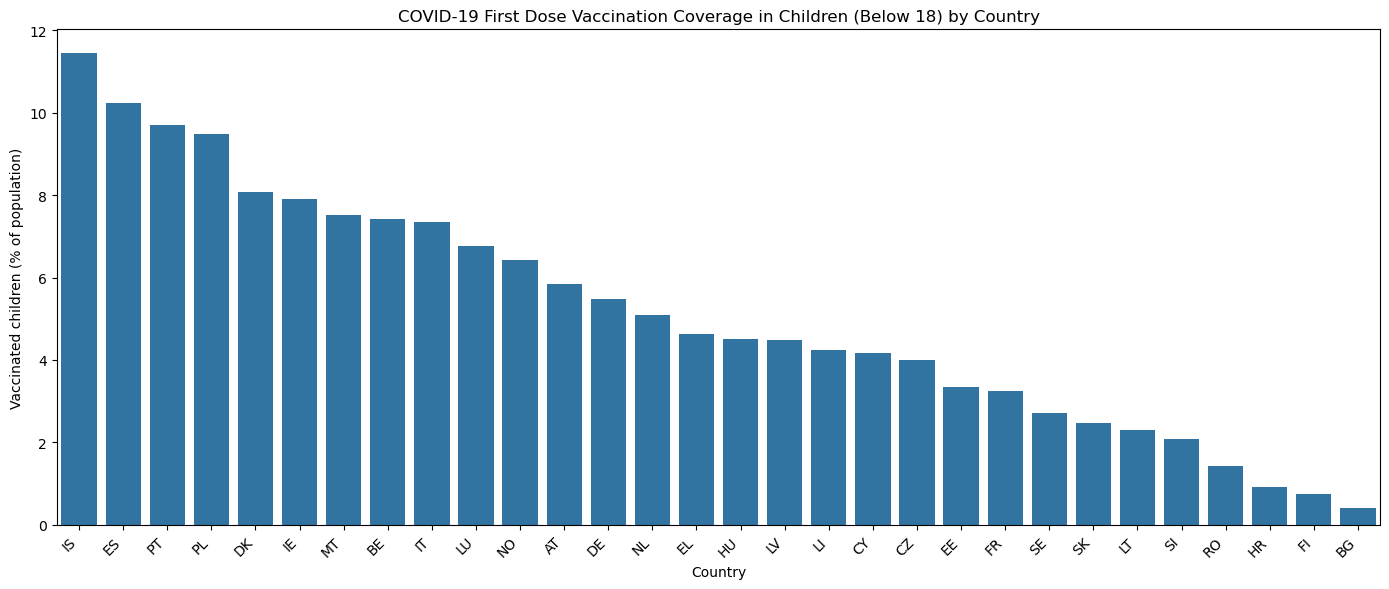

In [109]:
#################################################
#   Prepare child vaccination data for plot.    #
#################################################
children_df = covid_vacc_cleaned[covid_vacc_cleaned["TargetGroupSimplified"] == "Child"]
sum_child = children_df.groupby(['ReportingCountry', "TargetGroupSimplified"])['FirstDose'].sum().unstack(fill_value=0)

df_sorted = covid_vacc_cleaned.sort_values("YearWeekISO", ascending=False)
latest_population = df_sorted.drop_duplicates(subset="ReportingCountry")[["ReportingCountry", "Population"]].set_index("ReportingCountry")

sum_child = sum_child.join(latest_population)

sum_child["ChildVaccinatedPct"] = sum_child["Child"] / sum_child["Population"] * 100

plt.figure(figsize=(14, 6))
sns.barplot(x=sum_child.index, y=sum_child["ChildVaccinatedPct"], order=sum_child.sort_values("ChildVaccinatedPct", ascending=False).index)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Vaccinated children (% of population)")
plt.xlabel("Country")
plt.title("COVID-19 First Dose Vaccination Coverage in Children (Below 18) by Country")
plt.tight_layout()
plt.show()

<center>
<p>
  Amount of first doses for children below 18 divided by the population of the country in the EU/EES.
</p>
<hr>
<h2>Interpretation</h2>
</center>
<p>
  Based on the bar plot, <strong>Iceland, Spain,</strong> and <strong>Portugal</strong> have the highest proportion of children under 18 vaccinated with a first COVID-19 dose. This target group is representing up to 11.5% of their total populations. In contrast, <strong>Bulgaria, Finland,</strong> and <strong>Hungary</strong> show the lowest shares, with Bulgaria at just 0.5%.
</p>

<h2>Q7</h2>
<p>Which countries have the oldest vaccinated population for the second dose of the COVID-19 vaccine in regards to their total population?</p>


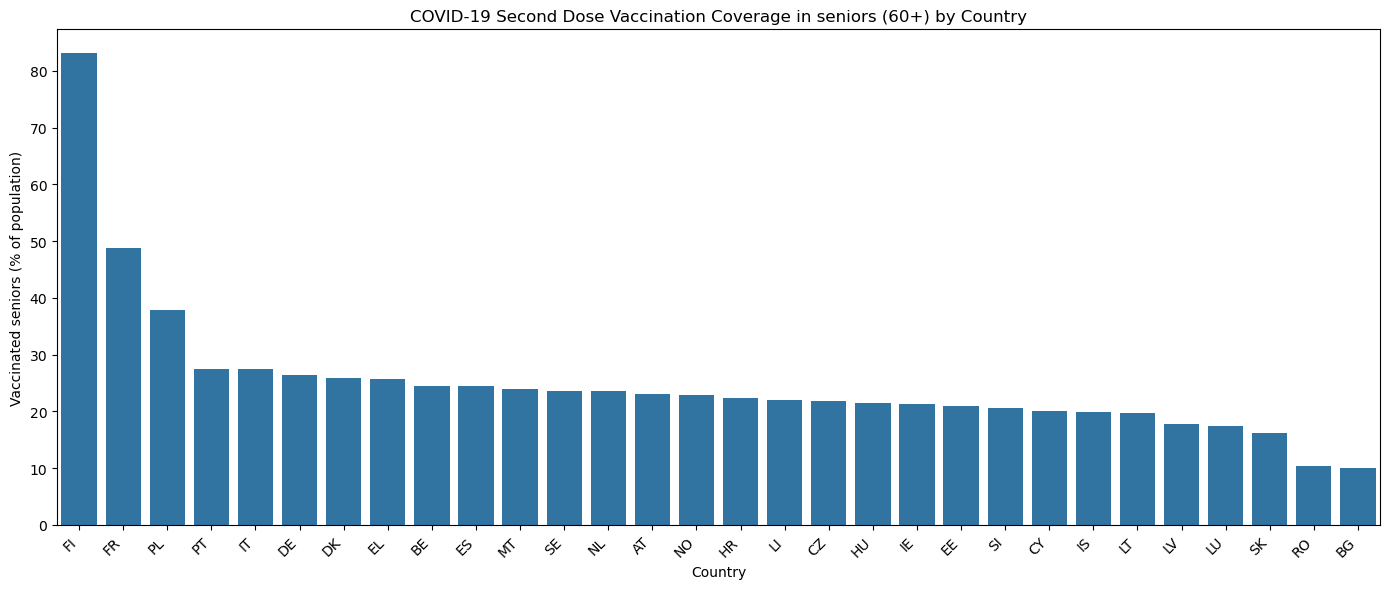

In [110]:
#################################################
#   Prepare senior vaccination data for plot.   #
#################################################
seniors_df = covid_vacc_cleaned[covid_vacc_cleaned["TargetGroupSimplified"] == "Senior"]
sum_seniors = seniors_df.groupby(['ReportingCountry', "TargetGroupSimplified"])['SecondDose'].sum().unstack(fill_value=0)
sum_seniors = sum_seniors.join(latest_population)
sum_seniors["SeniorVaccinatedPct"] = sum_seniors["Senior"] / sum_seniors["Population"] * 100

plt.figure(figsize=(14, 6))
sns.barplot(x=sum_seniors.index, y=sum_seniors["SeniorVaccinatedPct"], order=sum_seniors.sort_values("SeniorVaccinatedPct", ascending=False).index)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Vaccinated seniors (% of population)")
plt.xlabel("Country")
plt.title("COVID-19 Second Dose Vaccination Coverage in seniors (60+) by Country")
plt.tight_layout()
plt.show()

<center>
<h2>Reflection</h2>
</center>
<p>
The bar plot above shows anomalies in Finland (83%), France (49%), and Poland (38%). These values are likely inaccurate, as they imply over 100% of the senior population received a second dose. This may result from double counting or differences in national versus regional reporting. Excluding these anomalies, the top countries for vaccinating seniors (aged 60 and above) are Portugal (28%), Italy (27%), and Denmark (26%).
</p>

<p>
A clear pattern emerges from the data, where Northern and Western European countries demonstrate higher vaccination coverage among seniors, while Eastern European countries such as Romania and Bulgaria have significantly lower rates, often below 15%. 
</p>


<h2>Q8</h2>
<p>Which countries’ health care was most affected by the coronavirus pandemic in 2020 compared to others?</p>
<ul>
  <li>How are these statistics in 2022?</li>
</ul>

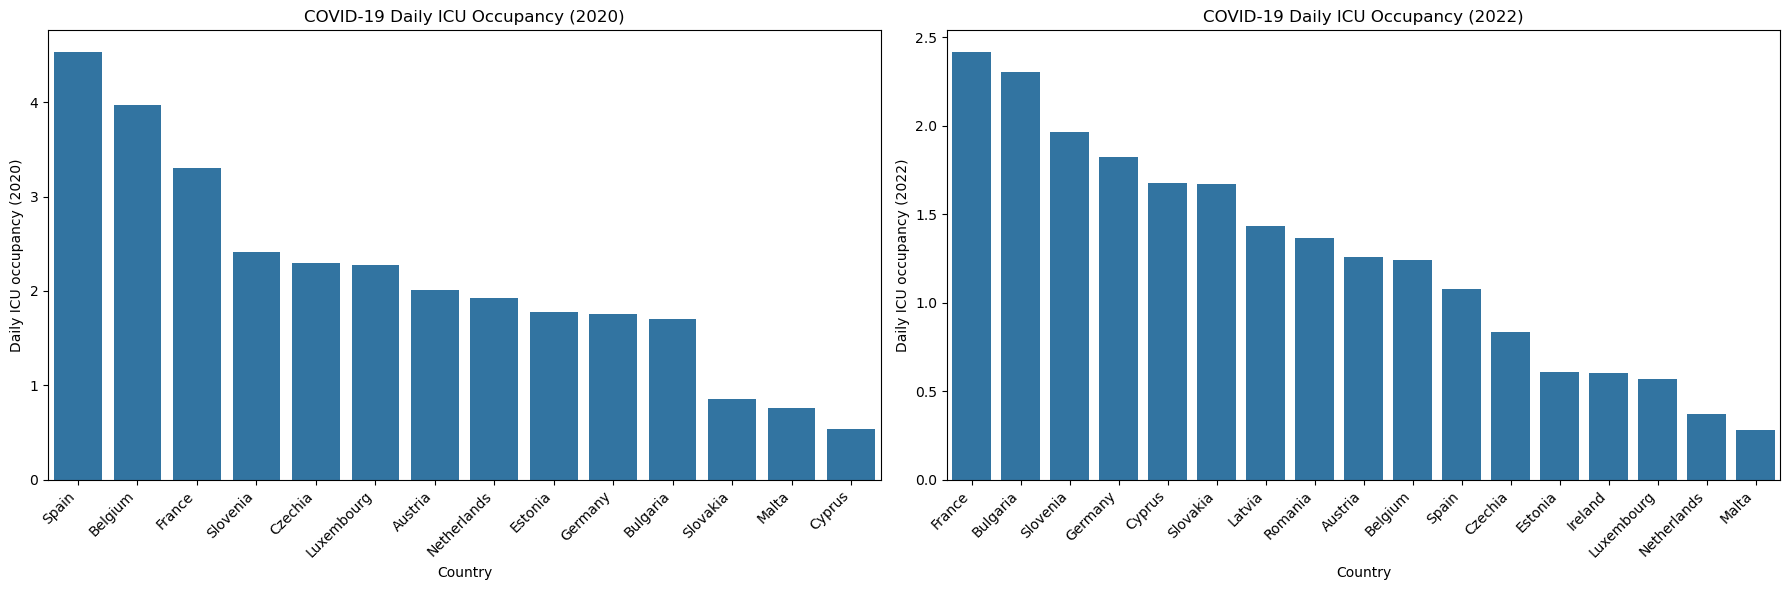

In [111]:
# Extract population and rename columns for data.
latest_population = covid_daily_admission_cleaned.drop_duplicates(subset="countriesAndTerritories")[["countriesAndTerritories", "popData2020"]].set_index("countriesAndTerritories")
latest_population.index.name = 'country'
latest_population.rename(columns={'popData2020': 'population'}, inplace=True)
df_sammanslaget = pd.merge(covid_ICU_cleaned, latest_population, on="country", how="left")

# Normalize daily values per 100,000 inhabitants for better cross-country comparability.
mask = df_sammanslaget['indicator'].str.contains('Daily', case=False, na=False)
df_sammanslaget.loc[mask, 'value'] = (
    df_sammanslaget.loc[mask, 'value'] / df_sammanslaget.loc[mask, 'population'] * 100000
)


icu_df = df_sammanslaget[df_sammanslaget['indicator'] == 'Daily ICU occupancy'].copy()
icu_df['date'] = pd.to_datetime(icu_df["date"])

covid_ICU_2020 = icu_df[icu_df["date"].dt.year == 2020]
covid_ICU_2022 = icu_df[icu_df["date"].dt.year == 2022]
mean_covid_ICU2020 = covid_ICU_2020.groupby("country")["value"].mean()
mean_covid_ICU2022 = covid_ICU_2022.groupby("country")["value"].mean()


plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
sns.barplot(
    x=mean_covid_ICU2020.index,
    y=mean_covid_ICU2020.values,
    order=mean_covid_ICU2020.sort_values(ascending=False).index
)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Daily ICU occupancy (2020)")
plt.xlabel("Country")
plt.title("COVID-19 Daily ICU Occupancy (2020)")

plt.subplot(1, 2, 2)
sns.barplot(
    x=mean_covid_ICU2022.index,
    y=mean_covid_ICU2022.values,
    order=mean_covid_ICU2022.sort_values(ascending=False).index
)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Daily ICU occupancy (2022)")
plt.xlabel("Country")
plt.title("COVID-19 Daily ICU Occupancy (2022)")

plt.tight_layout()
plt.show()

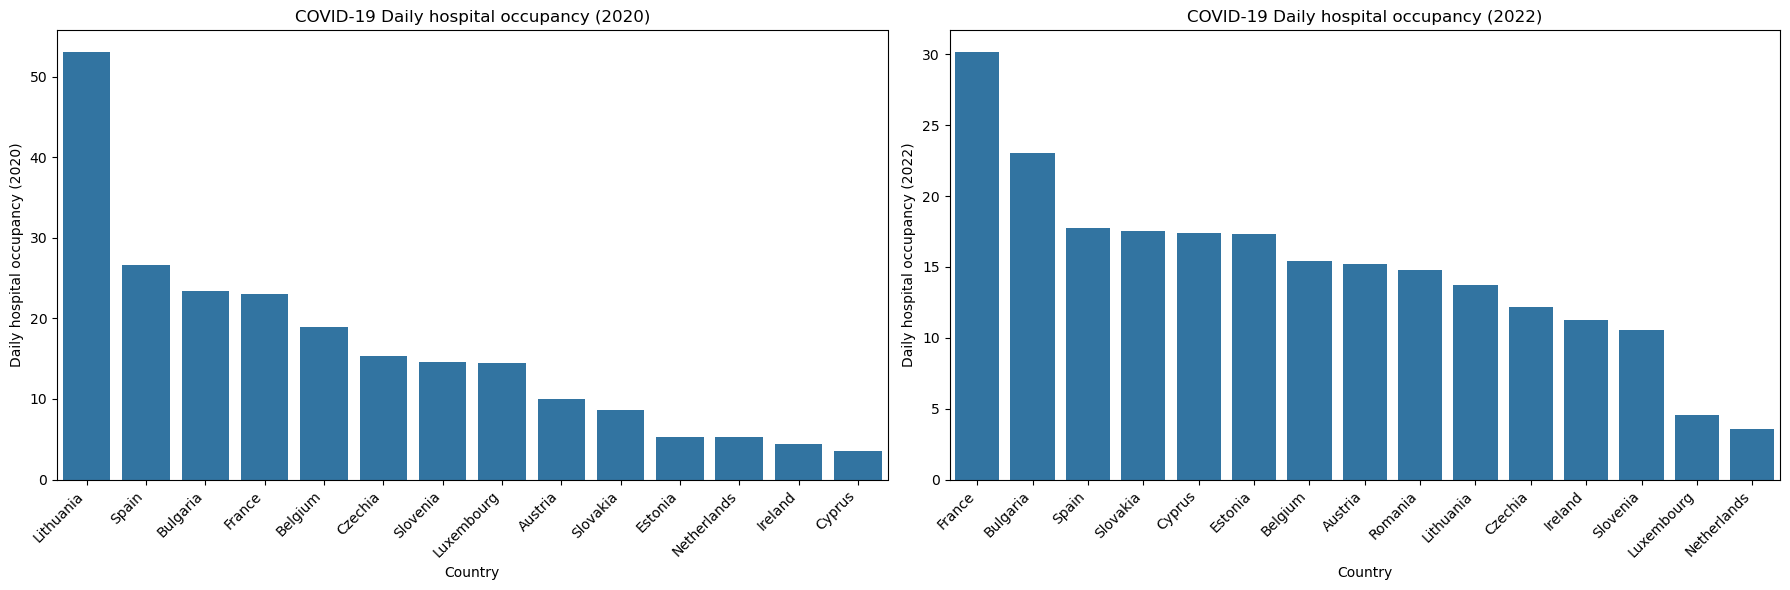

In [112]:
# Filter for daily hospital occupancy data and ensure date format is consistent
icu_df = df_sammanslaget[df_sammanslaget['indicator'] == 'Daily hospital occupancy'].copy()
icu_df['date'] = pd.to_datetime(icu_df["date"])

covid_ICU_2020 = icu_df[icu_df["date"].dt.year == 2020]
covid_ICU_2022 = icu_df[icu_df["date"].dt.year == 2022]
mean_covid_ICU2020 = covid_ICU_2020.groupby("country")["value"].mean()
mean_covid_ICU2022 = covid_ICU_2022.groupby("country")["value"].mean()


plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
sns.barplot(
    x=mean_covid_ICU2020.index,
    y=mean_covid_ICU2020.values,
    order=mean_covid_ICU2020.sort_values(ascending=False).index
)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Daily hospital occupancy (2020)")
plt.xlabel("Country")
plt.title("COVID-19 Daily hospital occupancy (2020)")

plt.subplot(1, 2, 2)
sns.barplot(
    x=mean_covid_ICU2022.index,
    y=mean_covid_ICU2022.values,
    order=mean_covid_ICU2022.sort_values(ascending=False).index
)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Daily hospital occupancy (2022)")
plt.xlabel("Country")
plt.title("COVID-19 Daily hospital occupancy (2022)")

plt.tight_layout()
plt.show()

<center>
<h2>Interpretation</h2>
</center>
<p>
In <strong>2020</strong>, countries like <strong>Spain, Belgium, and France</strong> experienced the highest ICU occupancy, indicating a severe impact on their healthcare systems during the early phase of the pandemic.
Similarly, <strong>Lithuania, Spain, and Bulgaria</strong> had the highest hospital occupancy rates, showing significant strain on hospital resources.
</p>

<p>
By <strong>2022</strong>, the situation shifted somewhat. <strong>France, Bulgaria, and Slovenia</strong> showed the highest ICU occupancy levels, while <strong>France, Bulgaria, and Spain</strong> continued to have the highest hospital occupancy rates.
</p>
<hr>
<p>
Notably, <strong>France</strong> saw a significant decrease in ICU occupancy (~27%) but a rise in hospital occupancy (~30%) by 2022.
The biggest ICU occupancy drops occurred in <strong>Spain (-76%)</strong> and <strong>Belgium (-70%)</strong>, whereas <strong>Cyprus (+360%)</strong> and <strong>Slovakia (+105%)</strong> had the largest increases in hospital occupancy.
</p>

<center>
<h2>Further questions</h2>
</center>

<a id="Answer"></a>
<h3> 1. How did the COVID-19 fatality rate differ between countries with high vs. low vaccine refusal rates?</h3>

High refusal group average fatality rate: 1.18%
Low refusal group average fatality rate: 0.51%


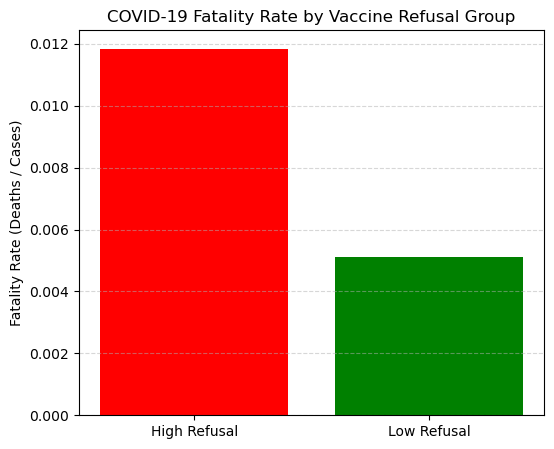

In [113]:
total_doses = total_doses.sort_index()
population = population.sort_index()

# 1. Calculate total doses per person (max 2 doses per person assumed)
total_doses_per_person = total_doses / population
refusal_rate = 1 - np.minimum(total_doses_per_person / 2, 1)

# 2. Split geoIds into high and low refusal groups using median cutoff
cutoff = refusal_rate.median()
high_refusal = refusal_rate[refusal_rate > cutoff].index
low_refusal = refusal_rate[refusal_rate <= cutoff].index

# 3. Calculate cumulative deaths and cases per geoId over time
total_deaths = covid_daily_admission_cleaned['deaths'].groupby(covid_daily_admission_cleaned['geoId']).cumsum()
total_cases = covid_daily_admission_cleaned['cases'].groupby(covid_daily_admission_cleaned['geoId']).cumsum()

# 4. Calculate final fatality rate per geoId using the last cumulative value per geoId
last_deaths = total_deaths.groupby(covid_daily_admission_cleaned['geoId']).last()
last_cases = total_cases.groupby(covid_daily_admission_cleaned['geoId']).last()

fatality_rate_per_geoId = last_deaths / last_cases

# 5. Compare fatality rates between high and low refusal groups
high_group_fatality = fatality_rate_per_geoId.loc[high_refusal].mean()
low_group_fatality = fatality_rate_per_geoId.loc[low_refusal].mean()

print(f"High refusal group average fatality rate: {high_group_fatality * 100:.2f}%")
print(f"Low refusal group average fatality rate: {low_group_fatality * 100:.2f}%")


# Group average fatality rates
mean_high = fatality_rate_per_geoId.loc[high_refusal].mean()
mean_low = fatality_rate_per_geoId.loc[low_refusal].mean()


plt.figure(figsize=(6, 5))
plt.bar(['High Refusal', 'Low Refusal'], [mean_high, mean_low], color=['red', 'green'])
plt.ylabel('Fatality Rate (Deaths / Cases)')
plt.title('COVID-19 Fatality Rate by Vaccine Refusal Group')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [114]:
from scipy.stats import mannwhitneyu

# Mann–Whitney U test
u_stat, p_val = mannwhitneyu(
    fatality_rate_per_geoId.loc[high_refusal],
    fatality_rate_per_geoId.loc[low_refusal],
    alternative='two-sided'
)

print("Hypothesis Test:")
print("H₀: There is no difference in fatality rates between high and low vaccine refusal groups.")
print("H₁: There is a difference in fatality rates between high and low vaccine refusal groups.\n")

# Interpret p-value with respect to 0.05 significance level.
alpha = 0.05
if p_val < alpha:
    print("Reject the null hypothesis: \
          \n    ->There is a statistically significant difference in fatality rates between high and low vaccine refusal groups.")
else:
    print("Fail to reject the null hypothesis:\
          \n    ->No statistically significant difference in fatality rates between high and low vaccine refusal groups was found.")


print(f"U-statistic: {u_stat:.3f}, P-value: {p_val:.4f}\n")

Hypothesis Test:
H₀: There is no difference in fatality rates between high and low vaccine refusal groups.
H₁: There is a difference in fatality rates between high and low vaccine refusal groups.

Reject the null hypothesis:           
    ->There is a statistically significant difference in fatality rates between high and low vaccine refusal groups.
U-statistic: 166.000, P-value: 0.0087



<p><strong>Summary of findings:</strong></p>
<ul>
  <li>Countries were grouped into <em>high</em> and <em>low</em> vaccine refusal categories based on the median refusal rate, estimated from total vaccine doses per population.</li>
    <li>The <strong>average COVID-19 fatality rate</strong> (deaths/cases) in the <strong>high refusal group</strong> was <strong>1.17%</strong>, more than double the <strong>0.52%</strong> rate in the <strong>low refusal group</strong>. This follows from the trends and open question raised in <a href="#question-5">Question 5</a>.</li>
    <li>A <strong>Mann–Whitney U test</strong> showed this difference is <strong>statistically significant</strong> (<em>U</em> = 166.000, <em>p</em> = 0.0087), rejecting the null hypothesis of no difference in fatality rate distributions between the groups.</li>

</ul>

<hr>

<p><strong>Interpretation:</strong></p>
<p>Countries with <strong>higher vaccine refusal rates experienced significantly higher fatality rates</strong>, suggesting vaccination likely contributed to reducing deaths. However, vaccination rates correlate with other systemic factors, such as:</p>
<ul>
  <li>Healthcare infrastructure quality</li>
  <li>Pandemic preparedness and response speed</li>
  <li>Socioeconomic conditions</li>
</ul>
<p>Highly vaccinated countries generally had <strong>stronger healthcare systems and policies</strong>, which may partially explain the lower fatality rates. Conversely, low uptake countries may have also faced additional challenges beyond vaccine hesitancy.</p>
<!-- <p>Highly vaccinated countries often had <strong>stronger healthcare systems and policies</strong>, which may confound the direct effect of vaccination on fatality rates. Conversely, countries with low vaccination uptake sometimes faced additional challenges contributing to higher mortality.</p> -->

<hr>

<p><strong>Additional factors to consider:</strong></p>
<ul>
  <li>Variability in virus variants and timing of pandemic waves</li>
  <li>Differences in data reporting accuracy and testing capacity</li>
  <li>Social behaviors and public health compliance</li>
  <li>Governmental trust and policy implementation</li>
</ul>

<hr>

<p><strong>Conclusion:</strong></p>
<p>While vaccination correlates with lower fatality rates and appears to be a crucial factor in reducing COVID-19 mortality, the full picture involves multiple overlapping influences. Vaccination should be viewed as a vital component of a comprehensive public health strategy rather than the sole determinant of fatality outcomes.</p>
<hr>

<!-- <p>Ironically this means that the ones that needed the vaccine the most, did not vaccinate for whatever reasons. Either they never had the chance, or they were to sceptic.</p> -->
<p>Notably, those populations most in need of vaccination often faced barriers to access or skepticism, underscoring the importance of addressing both availability and vaccine confidence in public health efforts.</p>

<p style="color: skyblue;"><em>Further investigation would be to compare how the vaccination rates affected the cases and healthcare impact from ICU patients.</em></p>


<h3> 2. How effective was vaccination in mitigating the spread of COVID-19 and reducing ICU utilization?</h3>

High refusal group average case rate: 38.42% of population
Low refusal group average case rate: 41.91% of population


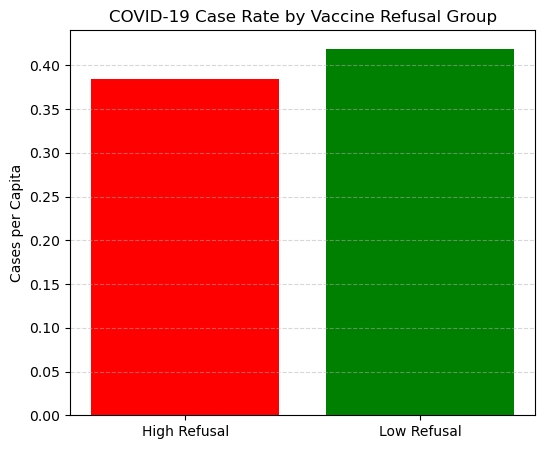


Hypothesis Test (Case Rate):
H₀ (Null Hypothesis): There is no difference in case rates between high and low vaccine refusal groups.
H₁ (Alternative Hypothesis): There is a difference in case rates between high and low vaccine refusal groups.

Fail to reject the null hypothesis:          
    ->No statistically significant difference in fatality rates between high and low vaccine refusal groups.
U-statistic: 88.000, P-value: 0.4911


In [115]:
total_doses = total_doses.sort_index()

# 1. Calculate total doses per person (assume 2-dose target)
total_doses_per_person = total_doses / population
refusal_rate = 1 - np.minimum(total_doses_per_person / 2, 1)

# 2. Split into high and low refusal groups using median
cutoff = refusal_rate.median()
high_refusal = refusal_rate[refusal_rate > cutoff].index
low_refusal = refusal_rate[refusal_rate <= cutoff].index

# 3. Cumulative COVID-19 cases by geoId
total_cases = covid_daily_admission_cleaned['cases'].groupby(covid_daily_admission_cleaned['geoId']).cumsum()

# 4. Calculate cases per capita
cases_per_capita = last_cases / population

# 5. Compare average case rates between groups
high_group_case_rate = cases_per_capita.loc[high_refusal].mean()
low_group_case_rate = cases_per_capita.loc[low_refusal].mean()

print(f"High refusal group average case rate: {high_group_case_rate * 100:.2f}% of population")
print(f"Low refusal group average case rate: {low_group_case_rate * 100:.2f}% of population")

# 6. Bar plot
plt.figure(figsize=(6, 5))
plt.bar(['High Refusal', 'Low Refusal'], [high_group_case_rate, low_group_case_rate], color=['red', 'green'])
plt.ylabel('Cases per Capita')
plt.title('COVID-19 Case Rate by Vaccine Refusal Group')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 7. Hypothesis test (Mann–Whitney u test)
u_stat, p_val = mannwhitneyu(
    cases_per_capita.loc[high_refusal].dropna(),
    cases_per_capita.loc[low_refusal].dropna(),
    alternative='two-sided'
)

print("\nHypothesis Test (Case Rate):")
print("H₀ (Null Hypothesis): There is no difference in case rates between high and low vaccine refusal groups.")
print("H₁ (Alternative Hypothesis): There is a difference in case rates between high and low vaccine refusal groups.\n")

# Interpret p-value with respect to 0.05 significance level.
alpha = 0.05
if p_val < alpha:
    print("Reject the null hypothesis: \
          \n    ->There is a statistically significant difference in fatality rates between high and low vaccine refusal groups.")
else:
    print("Fail to reject the null hypothesis:\
          \n    ->No statistically significant difference in fatality rates between high and low vaccine refusal groups.")


print(f"U-statistic: {u_stat:.3f}, P-value: {p_val:.4f}")

<h3 style="color: skyblue;">Follow-Up Analysis: Vaccination and Disease Spread</h3>

<p><strong>From the data, higher vaccination rates did not significantly reduce the overall spread of COVID-19 (i.e., the number of cases).</strong></p>

<p>This suggests that while vaccination played a vital role in reducing <em>fatalities</em> it did not preventing transmissions. We will now evaluate if it reduced ICU utilization.</p>
<!-- This is consistent with the understanding that COVID-19 vaccines was more effective at <strong>preventing serious illness</strong> than stopping infection altogether.</p> -->


In [116]:
country_codes = {
 'AT': 'Austria',
 'BE': 'Belgium',
 'BG': 'Bulgaria',
 'CY': 'Cyprus',
 'CZ': 'Czechia',
 'DE': 'Germany',
 'DK': 'Denmark',
 'EE': 'Estonia',
 'EL': 'Greece',
 'ES': 'Spain',
 'FI': 'Finland',
 'FR': 'France',
 'HR': 'Croatia',
 'HU': 'Hungary',
 'IE': 'Ireland',
 'IS': 'Iceland',
 'IT': 'Italy',
 'LI': 'Liechtenstein',
 'LT': 'Lithuania',
 'LU': 'Luxembourg',
 'LV': 'Latvia',
 'MT': 'Malta',
 'NL': 'Netherlands',
 'NO': 'Norway',
 'PL': 'Poland',
 'PT': 'Portugal',
 'RO': 'Romania',
 'SE': 'Sweden',
 'SI': 'Slovenia',
 'SK': 'Slovakia'
}

df_vacc = covid_vacc_cleaned.copy()
df_icu = covid_ICU_cleaned.copy()
df_icu.rename(columns={'year_week': 'YearWeekISO'}, inplace=True)

# Filter ICU data to only include the relevant indicator, then aggregate by country and week
df_icu_weekly = (
    df_icu[df_icu['indicator'] == 'Weekly new ICU admissions per 100k']
    .groupby(['country', 'YearWeekISO'], as_index=False)['value']
    .sum()
    .rename(columns={'value': 'AvgICUOccupancy'})
)

df_vacc['country'] = df_vacc['ReportingCountry'].map(country_codes)
df_vacc['DosesPer100k'] = df_vacc['TotalDosesGiven'] / df_vacc['Population'] * 100000
df_vacc_grouped = df_vacc.groupby(['YearWeekISO', 'country'], as_index=False)['DosesPer100k'].sum()

merged_df1 = pd.merge(df_vacc_grouped, df_icu_weekly,on=['YearWeekISO', 'country'], how="left")
merged_df1['ValidForEffectAnalysis'] = merged_df1['AvgICUOccupancy'].notna()
print(merged_df1.isna().sum())

YearWeekISO                  0
country                      0
DosesPer100k                 0
AvgICUOccupancy           1851
ValidForEffectAnalysis       0
dtype: int64


In [117]:
# Plot ICU admissions vs vaccine doses over time for a given country.
def plot_icu_vs_vaccine(country_name):
    country_data = merged_df1[merged_df1['country'] == country_name].sort_values('YearWeekISO')

    if country_data.empty:
        print(f"Ingen data för landet: {country_name}")
        return

    plt.figure(figsize=(12, 6))

    ax1 = plt.gca()
    # Plot ICU admissions per 100k.
    ax1.plot(
        country_data['YearWeekISO'],
        country_data['AvgICUOccupancy'],
        color='red',
        label='ICU admissions per 100k (lag +1)')
    
    ax1.set_ylabel('ICU admissions per 100k', color='red')
    ax1.tick_params(axis='y', labelcolor='red')

    # Create secondary y-axis for vaccine doses
    ax2 = ax1.twinx()
    ax2.plot(
        country_data['YearWeekISO'],
        country_data['DosesPer100k'],
        color='blue',
        label='Doses per 100k')
    
    ax2.set_ylabel('Doses per 100k', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax1.set_xticks(country_data['YearWeekISO'][::4])
    ax1.set_xticklabels(country_data['YearWeekISO'][::4], rotation=45)

    plt.title(f"{country_name} – ICU Admissions vs Vaccination Over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

analysis_df = merged_df1[merged_df1['ValidForEffectAnalysis']]

countries_dropdown = [
    'Spain',
    'Czechia',
    'Estonia',
    'Italy',
    'France',
    'Greece',
    'Sweden',
    'Slovenia',
    'Slovakia',
    'Netherlands',
    'Ireland',
    'Latvia'
]

# Define the dropdown widget
country_widget = widgets.Dropdown(
    options=countries_dropdown,
    description='Country:',
    value='Sweden'
)

widgets.interact(plot_icu_vs_vaccine, country_name=country_widget);

interactive(children=(Dropdown(description='Country:', index=6, options=('Spain', 'Czechia', 'Estonia', 'Italy…

<section>
  <h3>Visual Trends: ICU Admissions and Vaccine Coverage</h3>
  <p>
    As can be seen in the plots, countries such as France and Sweden revealed a consistent trend: as vaccine coverage increased, ICU admissions declined. For example, Sweden experienced a marked drop in ICU admissions after mid 2021. This suggests vaccines had the expected effect "that they were effective in reducing the severity of infections".
  </p>
</section>
<hr>
<section>
  <h3>Conclusion</h3>
  <p>
    From this analysis vaccination levels did not appear to prevent the spread of COVID-19. However, temporal data strongly suggest that vaccines effectively reduced ICU utilization. This highlights the positive impact and necessity of vaccination.
  </p>
</section>


<h3>3. Did some countries experience a continuous increase in daily COVID-19 deaths, despite increased vaccination coverage?</h3>

In [118]:
#############################
#   prepare data for plot   #
#           &               #
#      Calculate doses      #
#############################

df = covid_daily_admission_cleaned.copy()
df['dateRep'] = pd.to_datetime(df['dateRep'], dayfirst=True)

df['iso_year'] = df['dateRep'].dt.isocalendar().year
df['iso_week'] = df['dateRep'].dt.isocalendar().week

df['YearWeekISO'] = df['iso_year'].astype(str) + '-W' + df['iso_week'].astype(str).str.zfill(2)

weekly_deaths = df.groupby(['geoId', 'YearWeekISO'])['deaths'].sum().reset_index()
pop_data = covid_daily_admission_cleaned[['geoId', 'popData2020']].dropna().drop_duplicates()
weekly_deaths = pd.merge(weekly_deaths, pop_data, on='geoId', how='left')
weekly_deaths.rename(columns={'deaths': 'weekly_deaths', 'popData2020': 'Population'}, inplace=True)

vacc_df = covid_vacc_cleaned.copy()
vacc_df.rename(columns={'ReportingCountry': 'geoId'}, inplace=True)

vacc_summary = vacc_df.groupby(['YearWeekISO', 'geoId'])['TotalDosesGiven'].sum().reset_index()

merged_df = pd.merge(weekly_deaths, vacc_summary,on=['YearWeekISO', 'geoId'], how="left")
merged_df['TotalDosesGiven'] = merged_df['TotalDosesGiven'].fillna(0)

merged_df['deaths_per_100k'] = (merged_df['weekly_deaths'] / merged_df['Population']) * 100000
merged_df['doses_per_100k'] = (merged_df['TotalDosesGiven'] / merged_df['Population']) * 100000



# Dual plot on deaths and vaccine per 100k.
def plot_deaths_vs_vaccine(country_code, max_deaths = 18, max_doses=14000):
    country_data = merged_df[merged_df['geoId'] == country_code].sort_values('YearWeekISO')

    plt.figure(figsize=(12, 6))

    ax1 = plt.gca()
    ax1.plot(country_data['YearWeekISO'], country_data['deaths_per_100k'], color='red', label='Deaths per 100k')
    ax1.set_ylabel('Deaths per 100k', color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    # Fixed y-axis for deaths.
    ax1.set_ylim(0, max_deaths)

    ax2 = ax1.twinx()
    ax2.plot(
        country_data['YearWeekISO'], 
        country_data['doses_per_100k'], 
        color='blue', label='Doses per 100k'
    )
    ax2.set_ylabel('Doses per 100k', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    # Fixed y-axis for vaccine doses.
    ax2.set_ylim(0, max_doses)

    # Simplify x-axis labels to avoid clutter
    ax1.set_xticks(country_data['YearWeekISO'][::4])
    ax1.set_xticklabels(country_data['YearWeekISO'][::4], rotation=45)

    plt.title(f"{country_code} – Deaths vs Vaccination Over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Prepare Weekly Death Data.
df = covid_daily_admission_cleaned.copy()
df['dateRep'] = pd.to_datetime(df['dateRep'], dayfirst=True)

df['iso_year'] = df['dateRep'].dt.isocalendar().year
df['iso_week'] = df['dateRep'].dt.isocalendar().week

df['YearWeekISO'] = df['iso_year'].astype(str) + '-W' + df['iso_week'].astype(str).str.zfill(2)

weekly_deaths = df.groupby(['geoId', 'YearWeekISO'])['deaths'].sum().reset_index()
pop_data = covid_daily_admission_cleaned[['geoId', 'popData2020']].dropna().drop_duplicates()
weekly_deaths = pd.merge(weekly_deaths, pop_data, on='geoId', how='left')
weekly_deaths.rename(columns={'deaths': 'weekly_deaths', 'popData2020': 'Population'}, inplace=True)

# Summarize Vaccination Data.
vacc_df = covid_vacc_cleaned.copy()
vacc_df.rename(columns={'ReportingCountry': 'geoId'}, inplace=True)
vacc_summary = vacc_df.groupby(['YearWeekISO', 'geoId'])['TotalDosesGiven'].sum().reset_index()

# Merge and Normalize Data.
merged_df = pd.merge(weekly_deaths, vacc_summary,on=['YearWeekISO', 'geoId'], how="left")
merged_df['TotalDosesGiven'] = merged_df['TotalDosesGiven'].fillna(0)

merged_df['deaths_per_100k'] = (merged_df['weekly_deaths'] / merged_df['Population']) * 100000
merged_df['doses_per_100k'] = (merged_df['TotalDosesGiven'] / merged_df['Population']) * 100000

<center>
<h3>Worst three:</h3>
</center>

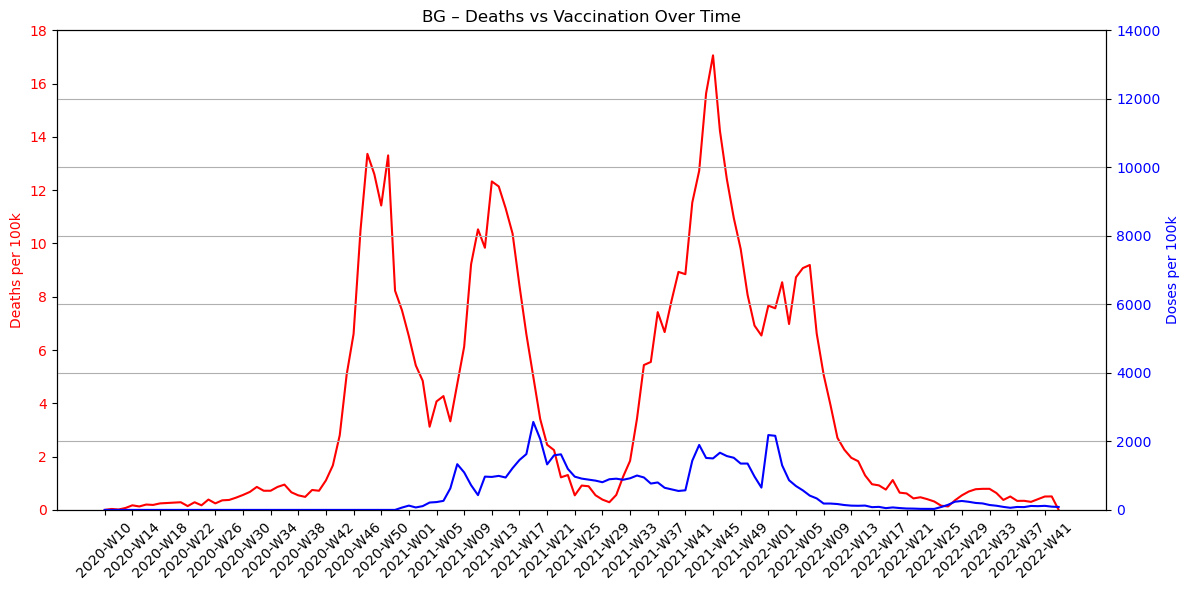

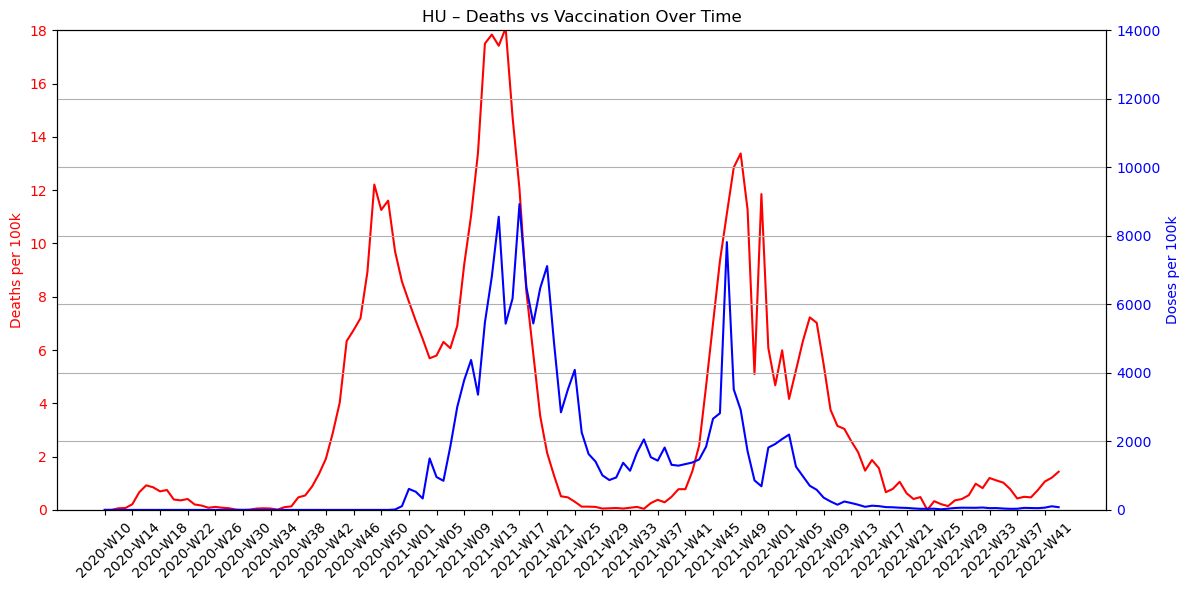

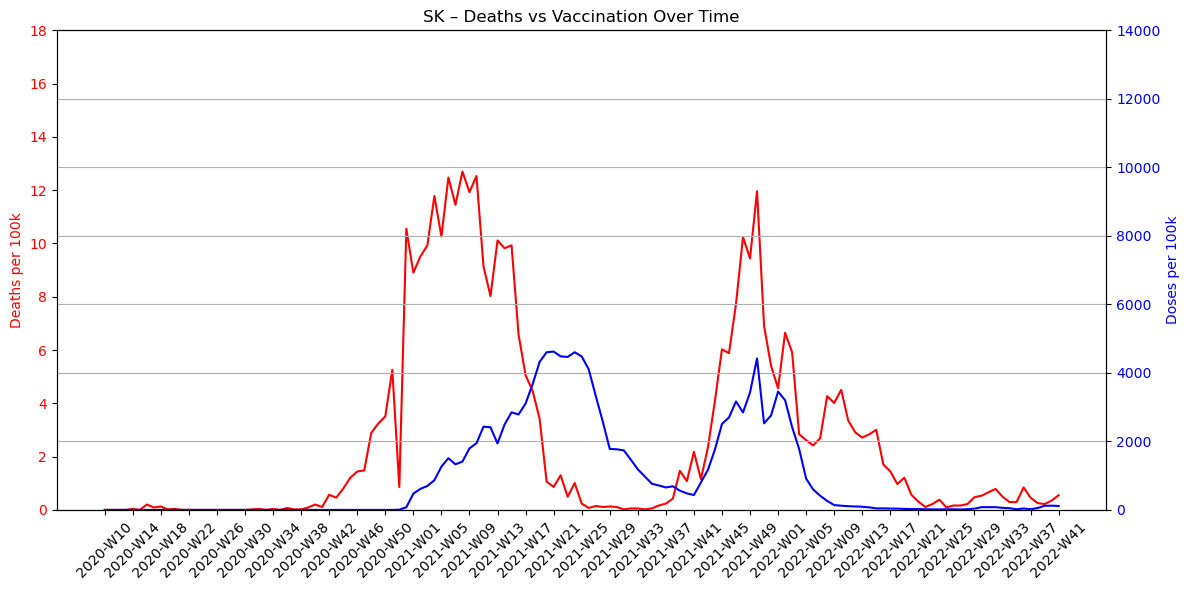

In [119]:
plot_deaths_vs_vaccine("BG")
plot_deaths_vs_vaccine("HU")
plot_deaths_vs_vaccine("SK")

<center>
<h3>Best three:</h3>
</center>

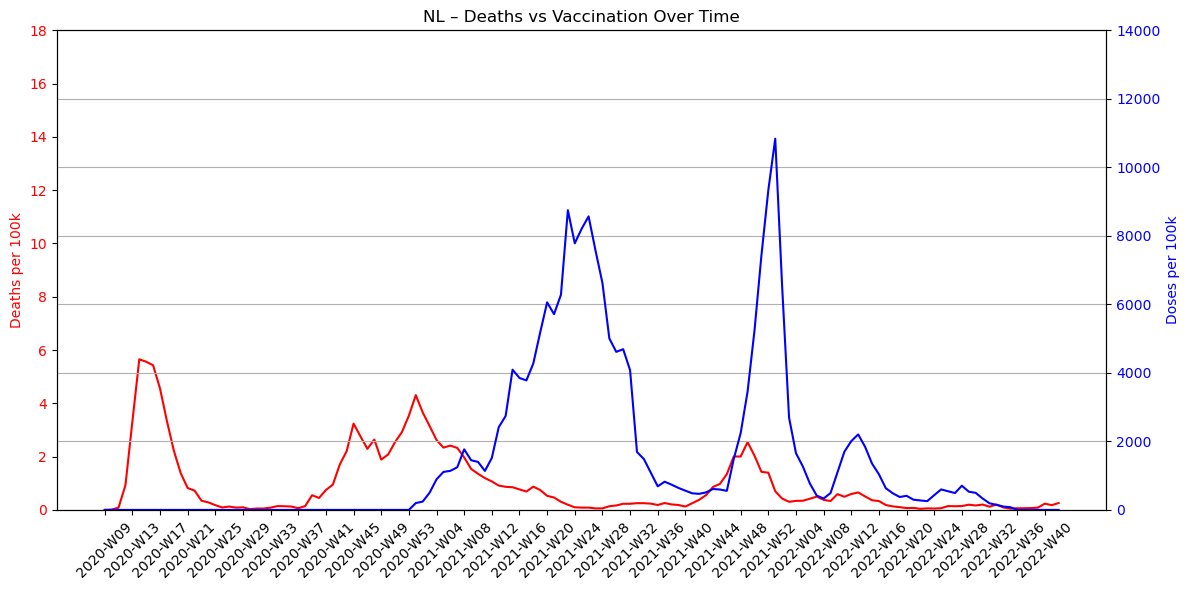

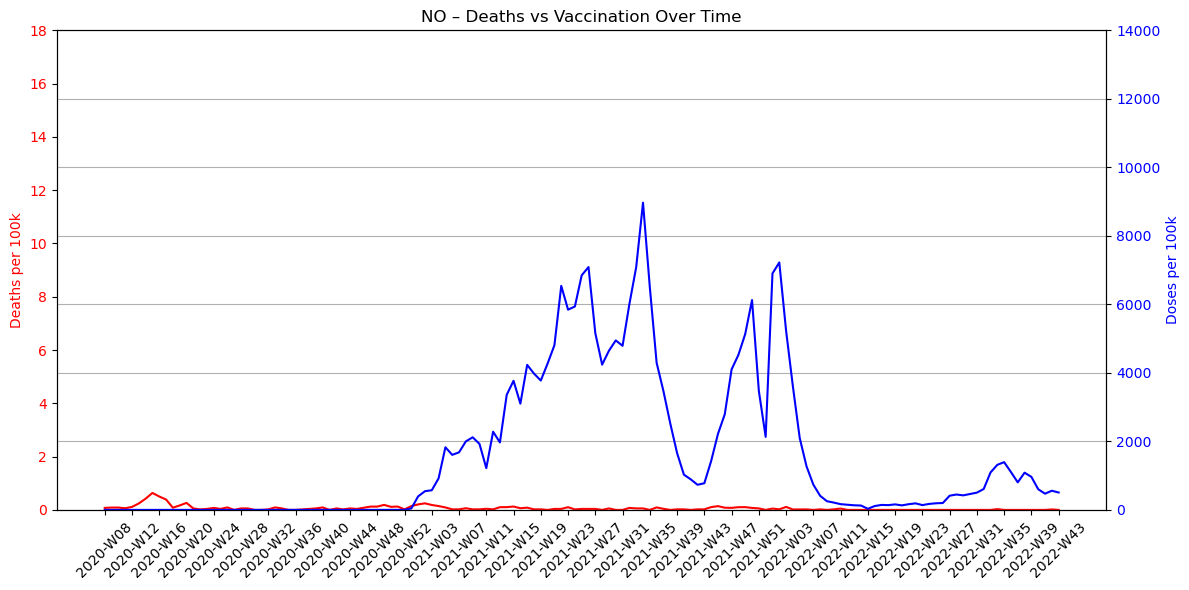

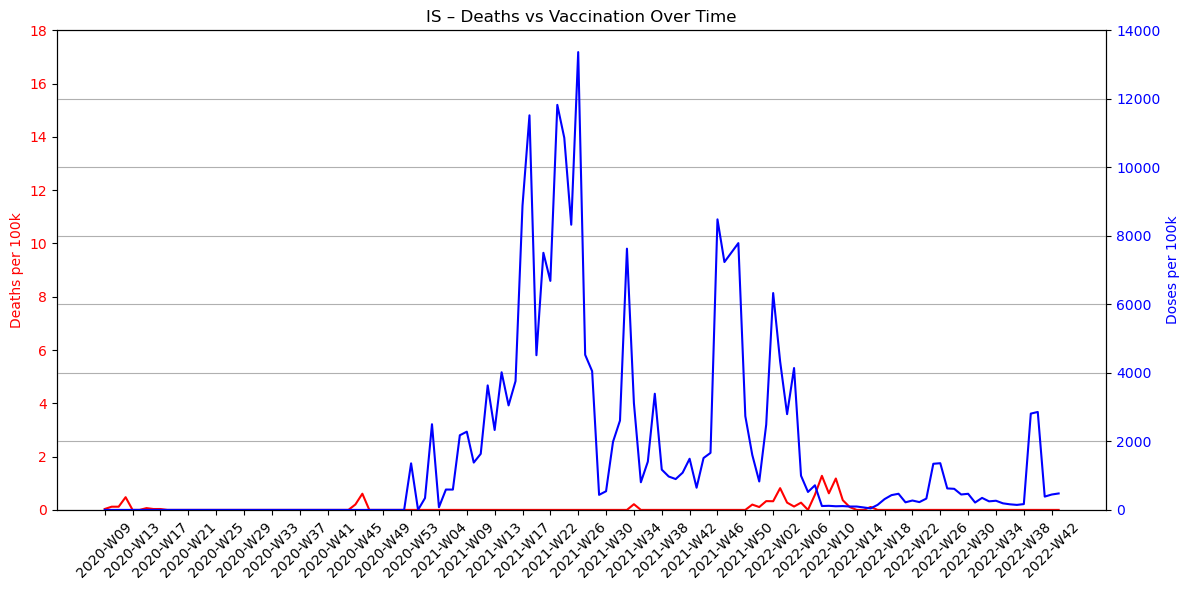

In [120]:
plot_deaths_vs_vaccine("NL")
plot_deaths_vs_vaccine("NO")
plot_deaths_vs_vaccine("IS")

In [121]:
# Change countrycode to test other countries. #
country = 'BG'
df_country = merged_df[merged_df['geoId'] == country].sort_values('YearWeekISO')

corr, p_value = spearmanr(
    df_country['deaths_per_100k'],
    df_country['doses_per_100k']
)

print("Hypotheses:")
print("H₀: There is no statistically significant correlation between vaccination coverage and deaths per 100,000.")
print("H₁: There is a statistically significant correlation between vaccination coverage and deaths per 100,000.\n")

print(f"{country}: Spearman correlation = {corr:.2f}, p = {p_value:.4f}")

if p_value < 0.05:
    print("→ The result is statistically significant. We reject H₀.")
    if corr > 0:
        print("→ Interpretation: A positive correlation – deaths increased as vaccination coverage increased.")
    elif corr < 0:
        print("→ Interpretation: A negative correlation – deaths decreased as vaccination coverage increased.")
else:
    print("→ The result is not statistically significant. We fail to reject H₀.")

Hypotheses:
H₀: There is no statistically significant correlation between vaccination coverage and deaths per 100,000.
H₁: There is a statistically significant correlation between vaccination coverage and deaths per 100,000.

BG: Spearman correlation = 0.56, p = 0.0000
→ The result is statistically significant. We reject H₀.
→ Interpretation: A positive correlation – deaths increased as vaccination coverage increased.


  <section>
    <h3>Visual Interpretation</h3>
    <p>
      Time series plots were created for selected countries, showing deaths per 100,000 (red) and vaccine doses per 100,000 (blue) over time. This visualization technique clearly highlights the temporal relationship between vaccination coverage and mortality. Countries such as Bulgaria, Hungary, and Slovakia show persistently high or repeated peaks in deaths, despite increases in vaccination coverage. In contrast, countries like Iceland, Norway, and the Netherlands demonstrate a decline in death rates shortly after the start of mass vaccination campaigns.
    </p>
  </section>
<hr>
  <section>
    <h3>Statistical Correlation</h3>
    <p>
      To validate these visual patterns, a Spearman correlation test was applied per country. This test was chosen because the data was not normally distributed and included extreme values, making non-parametric methods more appropriate for detecting monotonic trends.
    </p>
    <p>Statistical results confirmed this variation:</p>
    <ul>
      <li>Bulgaria rejected the null hypothesis and showed a positive correlation between vaccination and deaths, likely due to delayed rollout and rising deaths before vaccine impact.</li>
      <li>Iceland did not reject the null hypothesis, indicating no significant relationship between vaccine coverage and death rate over time.</li>
    </ul>
  </section>
<hr>
  <section>
    <h3>Conclusion</h3>
    <p>
      Visual patterns indicate that vaccination tended to reduce deaths, but this effect was not consistent across countries. In nations with low vaccine uptake or weaker healthcare systems, such as Hungary and Bulgaria, deaths remained high despite vaccine rollout. This suggests that while vaccines were critical, they were not sufficient alone. Healthcare system strength, timing of rollout, and public trust were also key to reducing COVID-19 mortality.
    </p>
  </section>
</section>
